The aim of this practical is to use a new synthetic dataset: percolations through a rectangle, explained below. 

The advantage of using this dataset is that the inputs are small, so that the neural nets can be small but deep, and it is possible for you to compare many different net designs quickly, training only with a cpu. 

But the concept of percolation is 'deep': there is no simple logical description of when there is a percolating path across a rectangle. Logistic regression fails completely.  There are many paths from one side of the square to the other, and the neural network needs to be able to recognise all of them. The function required to do this is highly non-linear, and there are dependencies between more than 8 values in a 8x8 square. 

Ironically, there is a simple iterative Python function that easily computes whether a matrix percolates, using depth first search. This is very quick, uses little computation, and it is 100% accurate.  


Percolation is not an easy property for neural nets to recognise. Nobody has yet managed to design a neural net that gets 100% accuracy !! Even after 30,000 training examples...   I challenge you to try ! 

# Percolation data

To define some image data, we will consider small images, initially of size 8x8 in black and white (or 0 and 1). 

The first concept that we will try to teach a NN is whether there is a continuous path of "white" pixels between the two sides of the image.

The function `percolate` returns True is there is a continuous path between the left and right sides of a binary image. (Aspects of python that are used are sets, a while loop, and break. )  

In [38]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
from random import randint

In [40]:
# this function does a depth-first search across a matrix of 0s and 1s,
# looking for a path of 1s between the first and last columns of the matrix
# such a path is called a presculation path

def percolate(mat):

    """
    Returns true if there is a percolation path of path of 1s from col -1 of matrix of 0s and 1s    
    """
    nrows = mat.shape[0] # row 
    ncols = mat.shape[1] # col
    frontier = set()
    #print("row",nrows)
    #print("col",ncols)

    
    for i in range(0,nrows):
        if mat[i,0]:
            frontier.add((i,0))
    explored = set()
    flag = False #this will be returned if the frontier becomes empty without finding a filled 
                # pixel in the right-most column
    
    while frontier:  # frontiner evaluate the True in this context if it is non-empty
        r,c = frontier.pop()
        explored.add((r,c))
        if r > 0:  #North
            if mat[r-1,c]:
                coords = (r-1,c)
                if coords not in explored:
                    if coords not in frontier: # this order of testing in necessary since each element of explored has been in frontier
                        frontier.add(coords)

        if c < ncols-1: #East
            if mat[r,c+1]:
                if c+1 == mat.shape[1]-1: # subtract 1 ont col. percolate to the last column
                    flag = True
                    return flag
                coords = (r,c+1)
                if coords not in explored:
                    if coords not in frontier: #  this order if testing is necessary since each element of explored has been in frontier
                        frontier.add(coords)
        if r<nrows-1: #South
            if mat[r+1,c]:
                coords = (r+1,c) 
                if coords not in explored:
                    if coords not in frontier: #this order of testing in necessary since each element of explored has been in forntier
                        frontier.add(coords)
        if c > 0: #west 
            if mat[r,c-1]:
                coords = (r,c-1)
                if coords not in explored:
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier 
                        frontier.add(coords)
    return flag    
   

NNow test the percolate function. We will genrate random images with a probability 0.6 probability of 1 in each pixel.

(<matplotlib.image.AxesImage at 0x2c4cc1eee70>, False)

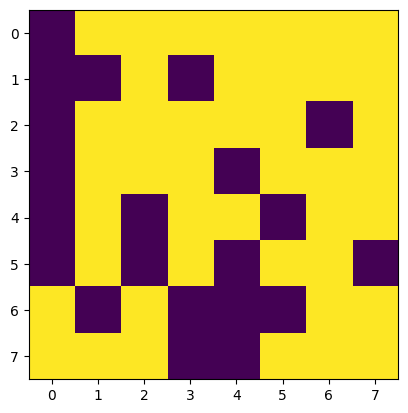

In [41]:
tmp = np.random.random([8,8]) > 0.4

plt.imshow(tmp), percolate(tmp)

#the first reult is an image; tthe second result is true if there is a continuous ath of yellow squareds form the left to the right side of the image. The path is continuous if the yellow squares are joined at one side:
#two yellow squares at the corner do not count as joined in a path
#you can evaluate this cell many times, and each time look at the resulting plt anwer, to check that you understand the notions of percolation, and also that rtthe percolate functon is getting it right.

In [42]:
#how many 8x* binary patterns are there
2.0**64

1.8446744073709552e+19

More than 18 billion, so our NN will need to generlise, because we will give it set of far fewer than 18 billion examples.

# Construct  datasets

In [43]:
import torch 
import torch.nn as nn
import torch.nn.functional as F # this includes tensor functions that we can use in backewards pass 
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim 

In [44]:
def make_percolation_datasets(side=8,threshold=0.42,n_examples=10):
    """
    This function generates an array of random images, in the form needed for Keras, and 
    then labels them as percolati# ng or not, using the percolate function. Roughly 50% of the
    images will have class 1 (percolating), so the dataset is likely to be reasonably balanced. 
    """
    X_data = (np.random.random([n_examples,side,side,1]) > threshold).astype(float) 
    Y_data = np.zeros([n_examples,1])
    for i in range(0,n_examples):
        if percolate(X_data[i,:,:,0]):
            Y_data[i,0] = 1
    return [(torch.tensor(x.astype(np.float32)).reshape(1,8,8), torch.tensor(float(y)).reshape(1) )  for x,y in zip( X_data, Y_data)]

# the types of the numbers in the tensors need to be float32: the most natural place to do this data conversion
# is in generating the datasets. 

In [45]:
training_set = make_percolation_datasets(n_examples=1000)
test_set = make_percolation_datasets(n_examples= 1000)

C:\Users\papap\AppData\Local\Temp\ipykernel_18560\2317440995.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [(torch.tensor(x.astype(np.float32)).reshape(1,8,8), torch.tensor(float(y)).reshape(1) )  for x,y in zip( X_data, Y_data)]


When we make a dataset, we should always chack  how many trhere are of each class:

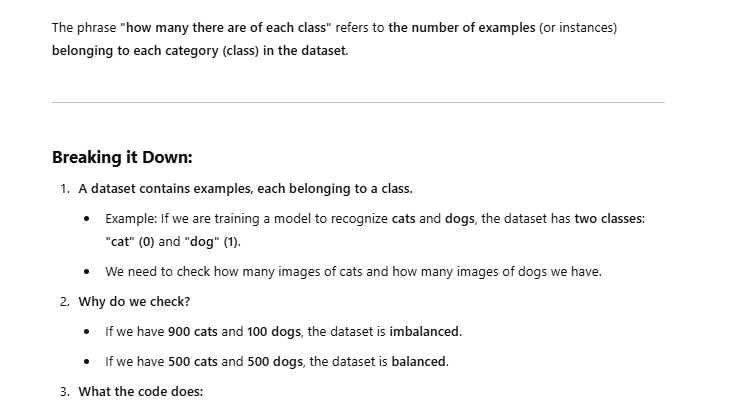

In [46]:
# this calculates the fraction of positive examples is the training set
sum([x[1].item() for x in training_set]) / len(training_set)  

0.475

The fraction of positive examples should ideally be close to 0.5  -- the default probability that a pixel is equal to 1 was chosen to ensure this. 

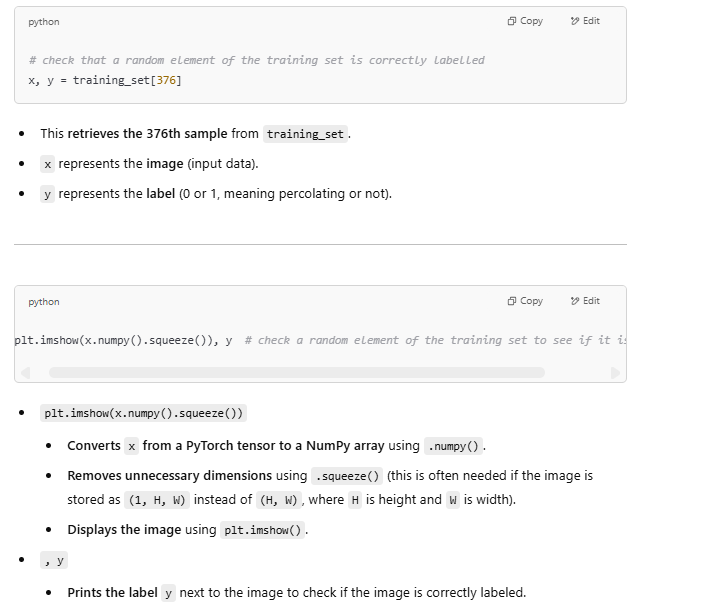

(<matplotlib.image.AxesImage at 0x2c4cc478500>, tensor([1.]))

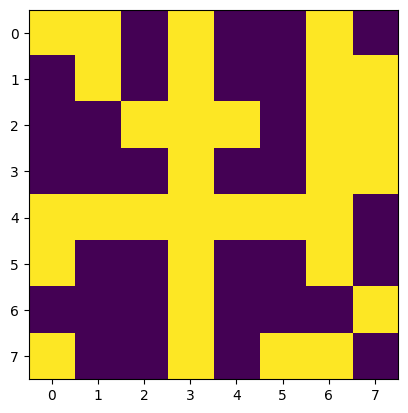

In [47]:
#check that a random element of the traing set is correctly labelled
x,y = training_set[376]
plt.imshow(x.numpy().squeeze()), y #chack a random element of the training set to see it is correct
#we need to squeeze it

If there is a continuous yellow path from the left side to the right side of the image, then the image "percolates" and the y value should be 1, otherwise the y value should be 0. 

# Constructing and training models

### A naive fully connected  Dense model for detecting percolation

(For tutorial purposes) the first thing to try is a naive model which pays no attention to the image structure. I don't expect this type of model to work well - but you may find a way to surprise me. 

In the model defined below, we flatten the image to a single row of values, and then we put in a single layer of neurons, each one of which is connected to all of the inputs. In other words, each neuron in this layer has 64 inputs, and then there is a final neuron which gives the output. 

You will (I hope) find that this is a terrible architecture for this problem. You will find that if there are too few neurons, then the model cannot even fit the training data.  If there are too many neurons in the Dense layer, then the model will fit the training data, but fail almost completely on the validation data: that is, the model will overfit badly. 

What would be the only way to get this poorly designed model to work? *Use a lot of training data!* . You can try constructing a much larger training set, and then see if you can get this model to classify correctly.  I doubt it - but you might succeed. 

Does adding more dense layers help?  Does adding regularisation - either `l1`, `l2`, or dropout - help? 

In [71]:
#our simplest neural net - it is just going to be a linear layer and then sigmoid
# (equivalent to softmax when there are only two classes)
# this si simply logisitc regression. we expect it too do badly on validation data, but it may overfitting training data
class NN1(nn.Module):

    def __init__(self):
        super(NN1,self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,1),
            nn.Sigmoid()) # a lineear layer(matrix, plus biases) with 784 input and 10 output. f we are going to make probabilistic categorical predictions, it is more flexible to allow unnormalised outputs, because we can use different functions for the predictions and in calculating the loss, as we shall soon see
        

    def forward(self,x): # forward pass
        x = self.layers(x)
        return x
        

In [72]:
net = NN1()


In [73]:
net.layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=64, out_features=1, bias=True)
  (2): Sigmoid()
)

In [74]:
#the state_dict is an useful attribute for a model, which contains a convinient names as keys for all the tensors
net.state_dict()

OrderedDict([('layers.1.weight',
              tensor([[-0.0483,  0.0895,  0.1249, -0.0102, -0.0982,  0.0444,  0.0394, -0.1095,
                        0.0930, -0.1202, -0.0188, -0.0966, -0.0577,  0.0113, -0.0478,  0.0863,
                        0.0396,  0.0369,  0.0579,  0.0368,  0.0862, -0.0824, -0.1024, -0.0553,
                       -0.0494,  0.1047,  0.0887, -0.0768, -0.1094, -0.1198, -0.1035, -0.0397,
                        0.0986, -0.0206,  0.1186, -0.0888,  0.0441, -0.0483,  0.1012, -0.0375,
                        0.0325, -0.1004, -0.0533,  0.0890, -0.1169,  0.0528,  0.0941,  0.0277,
                        0.1006,  0.0047,  0.0396,  0.1033, -0.0190, -0.0207,  0.0693,  0.0315,
                        0.0500, -0.1151,  0.0993, -0.1247,  0.0464, -0.0777, -0.1185, -0.0986]])),
             ('layers.1.bias', tensor([0.0309]))])

Now we will go step by step through all the stages of constructing a NN training loop, before putting it all toghether.

In [52]:
#dataLoader is an useful utility class provided by pytorch for exctracting minibatches form a large dataset
trainloader = torch.utils.data.DataLoader(training_set,batch_size=4, shuffle=True)
tesloader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=True)
# if you want to change the batch size, you need to define a new dataloader: 
# the dataloader is a lightweight class that just provides iteration over the dataset

In [53]:
#we construct a (temporay) iterator for trainloader, and we get the frst minibatch
tmpiter = iter(trainloader)
images, labels = next(tmpiter) # the minibatcgh is a list iof [images, labels]

#let's check what form the images and labels come in

In [54]:
labels

tensor([[1.],
        [1.],
        [0.],
        [0.]])

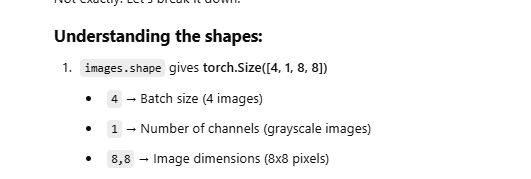

In [55]:
images.shape # always check the shapes of yyour tensor..

torch.Size([4, 1, 8, 8])

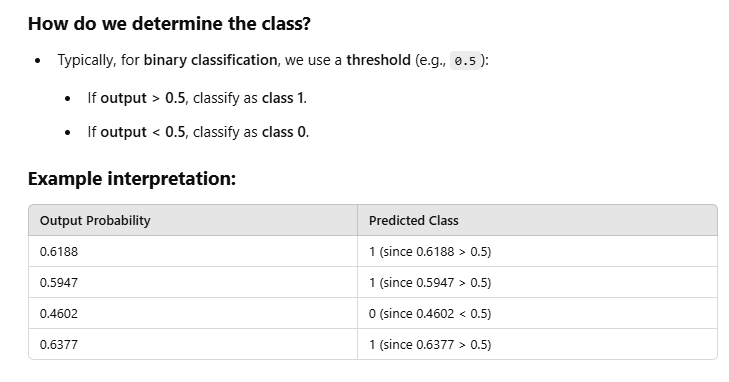

In [75]:
net.forward(images)

tensor([[0.5122],
        [0.4875],
        [0.4758],
        [0.5914],
        [0.6016],
        [0.4423],
        [0.4416],
        [0.4499]], grad_fn=<SigmoidBackward0>)

### which loss function?

We will use log-loss, because we are prediction classes(0 and 1 , non-percolation and percolating).

We could use two outpus, producted by softmax, and cross-entropy loss, as we did for MNIST.

But then we have highly redundant output weights: this may(I am not sure).

We can equivalently use one sigmoid neuron as output: the output of this neuron is the predicted probability of 1.

The loss function is providedby PyTorch: BCELoss. 



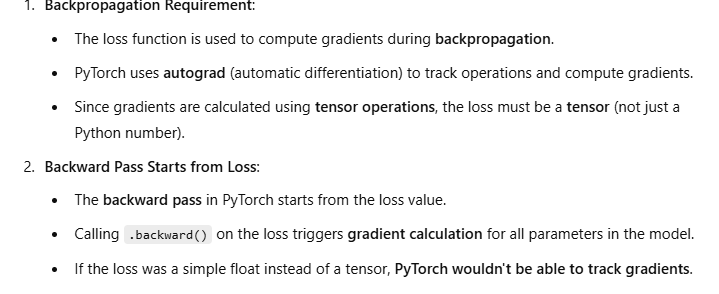
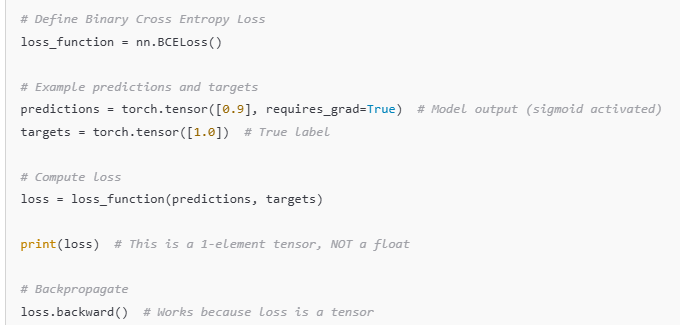

In [76]:
#BCELoss is buinary cross entropy loss:
#trhis takes a single probability(as output by a sigmoid neuron for example)
loss_function = nn.BCELoss()

#note that the result of loss function is a one element tensor: it needd to be tensor because we start the backward pass for the loss



In [77]:
loss_function(net.forward(images), labels)

tensor(0.7556, grad_fn=<BinaryCrossEntropyBackward0>)

-Log( 0.5 ) = 0.69, so we expect the average loss to be 0.7ish, as the network is not trained yet. 

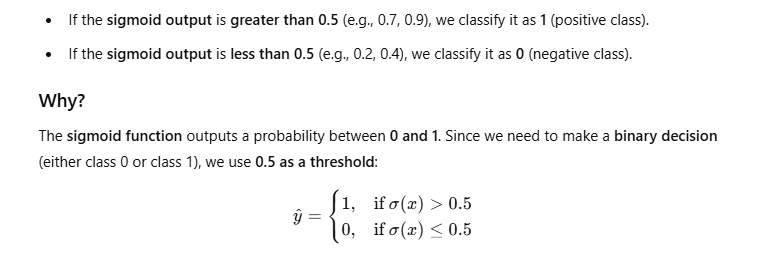

### Calculating Accuracy

How do we calculate accuracy, which is the percentageof correct prediction?

sigmoid output is > 0.5 as predicted a 1, and if it is < 0.5, as a predicted 0.

In [78]:
result = net.forward(images)
result

tensor([[0.5122],
        [0.4875],
        [0.4758],
        [0.5914],
        [0.6016],
        [0.4423],
        [0.4416],
        [0.4499]], grad_fn=<SigmoidBackward0>)

In [79]:
result > 0.5

tensor([[ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False]])

In [80]:
labels > 0.5

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True]])

In [81]:
#this expression gives the sum of the number of currect predicions in the batch 
# note that we acess the value of zero-dimetional tensor with .item()

A = sum((result > 0.5) == (labels > 0.5)).item()
print(A)

3


In [82]:
# this function calculates the loss and error rate on the validation set
# assuming that the output of the neural net nn is a single prediction probability,from a single sigmoid neuron.


def accuracy_and_loss_erorrRate(net, loss_function, dataloader):
    total_correct = 0 
    total_loss = 0.0
    total_examples = 0
    n_batches = 0

    with torch.no_grad(): #we do not need to compute the gradients when making predictions on the validation set
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            batch_loss = loss_function(outputs, labels) #this is averages over the batch
            n_batches += 1
            total_loss += batch_loss.item()
            #total_correct += sum((outputs > 0.5) == (labels > 0.5)).item() # number cuorrect in the minibatch
            total_correct += sum((outputs > 0.5)  == (labels > 0.5)).item() # number cuorrect in the minibatch
            total_examples += labels.size(0) # the number of labels, which is just the size of the minibATCH
            

        accuracy = total_correct / total_examples
        mean_loss = total_loss / n_batches

        error_rate = 1 - accuracy


    return (accuracy, mean_loss, error_rate)
    #print("Accuracy on test set: %d %%" %(100 * correct / total_examples))

In [83]:
#This testing accuracy and loss but I ADDED ERROR RATE AS WELL
print("ACCURACY, MEAN LOSS, ERORR_RATE")
accuracy_and_loss_erorrRate(net, loss_function, tesloader)

ACCURACY, MEAN LOSS, ERORR_RATE


(0.502, 0.714513466000557, 0.498)

ACCURACY SHUOLD BE 0.5ISH LOSS SHOULD BE 0.7ISH 

## Putting it all together: training a network

# 1 - accuracy to find training error.

In [85]:
# this cell is our pattern for nn initialisation and training 
# in the next section we convert it into a function...

trainloader = torch.utils.data.DataLoader(training_set, batch_size = 32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set,batch_size=32, shuffle=True)
#nn = NN1()
net = NN1()
optimizer1 = optim.RMSprop(net.parameters(), lr = 0.001)

for epoch in range(700):
   total_loss = 0
   total_correct = 0
   total_examples = 0
   n_mini_batches = 0
   #eorr

   train_list = []
   val_error_rate = []

   for i, n_mini_batch in enumerate(trainloader, 0):
      images, labels = n_mini_batch

      # zero the parameter gradients
      # all the parameters that are being updated are in the optimizer, 
      # so if we zero the gradients of all the tensors in the optimizer, 
      # that is the safest way to zero all the gradients

      optimizer1.zero_grad()

      outputs = net(images) # this in the forward pass

      loss= loss_function(outputs, labels)

      loss.backward() # it does the backward pass and computes all gradients

      optimizer1.step() #update all gradient

      n_mini_batches += 1 # kees track number of batches

      total_loss += loss.item() # summ up the loss for each batches. remeber the loss is zero-order tensor so to extract its value, we use .item() we cannot index no dimetions 


      # keep track of number
      total_correct += sum((outputs > 0.5) == (labels > 0.5)).item()
      total_examples += len(labels)


      # calculate statistic for each epoch and print them.
   # you can alter this code to accumulate these statistics into list/vectors and plot them
   epoch_training_accuracy = total_correct / total_examples
   epoch_training_loss = total_loss / n_mini_batches
   epoch_training_errotr = 1 - epoch_training_accuracy
   



   #val_accuracy, val_loss, val_error_rate = accuracy_and_loss(net, loss_function, testloader)
   val_accuracy, val_loss, val_error_rate = accuracy_and_loss_erorrRate(net, loss_function, testloader)   

   print('Epoch %d loss: %.3f acc: %.3f train_error_rate %.3f val_loss: %.3f val_acc: %.3f val_error_rate: %.3f'
         %(epoch+1, epoch_training_loss, epoch_training_accuracy,epoch_training_errotr, val_loss, val_accuracy, val_error_rate))
   








       
       

Epoch 1 loss: 0.711 acc: 0.487 train_error_rate 0.513 val_loss: 0.699 val_acc: 0.498 val_error_rate: 0.502
Epoch 2 loss: 0.700 acc: 0.506 train_error_rate 0.494 val_loss: 0.697 val_acc: 0.509 val_error_rate: 0.491
Epoch 3 loss: 0.698 acc: 0.514 train_error_rate 0.486 val_loss: 0.694 val_acc: 0.523 val_error_rate: 0.477
Epoch 4 loss: 0.693 acc: 0.524 train_error_rate 0.476 val_loss: 0.694 val_acc: 0.522 val_error_rate: 0.478
Epoch 5 loss: 0.690 acc: 0.533 train_error_rate 0.467 val_loss: 0.693 val_acc: 0.527 val_error_rate: 0.473
Epoch 6 loss: 0.690 acc: 0.543 train_error_rate 0.457 val_loss: 0.689 val_acc: 0.536 val_error_rate: 0.464
Epoch 7 loss: 0.683 acc: 0.559 train_error_rate 0.441 val_loss: 0.689 val_acc: 0.533 val_error_rate: 0.467
Epoch 8 loss: 0.685 acc: 0.562 train_error_rate 0.438 val_loss: 0.690 val_acc: 0.536 val_error_rate: 0.464
Epoch 9 loss: 0.682 acc: 0.574 train_error_rate 0.426 val_loss: 0.687 val_acc: 0.545 val_error_rate: 0.455
Epoch 10 loss: 0.679 acc: 0.597 train

As we might expect, logistic regression does not wokr well in identifying percolation. The concept is too complicated. We need a more complext network.

From now on it up yto you to design a range of network architectures, and see how well they do on this apparently simple problem.

you can try numbers of hidden units ranging from 10 to 1000;  you cna rry multipple leayers(but with less than 100 neurons per layers-connecting a layer with 1000 neurons to another vwith 1000 neurons needs a millions weights, wihich is too many for the CPU to handle in a reasdonable time).

when you difine a larger model, start off with a small number of epochs(2). you can then figure out how long a longer training will take. 


In [86]:
# a nn with one hidden layer
class NN_one_hidden(nn.Module):

    def __init__(self):
        super(NN_one_hidden, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,100), # try 100 hidden neurons
            nn.ReLU(),          

            nn.Linear(100,1),
            nn.Sigmoid())  #we are predicting only two classes , so we can used one sigmoiid neuron as output
        
    
    def forward(self,x): #computes the forward pass...
        x = self.layers(x)
        return x



        


In [87]:
nn1 = NN_one_hidden()
nn1

NN_one_hidden(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [88]:
class NN_two_hidden(nn.Module):

    def __init__(self):
        super(NN_two_hidden, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,100), 
            nn.ReLU(),

            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.Sigmoid()) # we callifier 0,1. so wwe can use signoiid.
        
    def forward(self,x): #computes the forward...
        x = self.layers(x)
        return x

In [89]:
nn2 = NN_two_hidden()
nn2

NN_two_hidden(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [90]:
class NN_three_hidden(nn.Module):

    def __init__(self):
        super(NN_three_hidden, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,1000),
            nn.ReLU(),

            nn.Linear(1000,100),
            nn.ReLU(),

            nn.Linear(100,100),
            nn.ReLU(),

            nn.Linear(100,1),
            #nn.Flatten(),
            nn.Sigmoid())

    def forward(self,x):
        x = self.layers(x)
        return x 

In [91]:
nn3 = NN_three_hidden()
nn3

NN_three_hidden(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [92]:
# this cell is our pattern for nn initialisation and training 
# in the next section we convert it into a function...

trainloader = torch.utils.data.DataLoader(training_set, batch_size = 32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set,batch_size=32, shuffle=True)
#nn3 = NN_three_hidden()
#net = NN1()
optimizer1 = optim.RMSprop(net.parameters(), lr = 0.001)

for epoch in range(700):
   total_loss = 0
   total_correct = 0
   total_examples = 0
   n_mini_batches = 0
   #eorr

   train_list = []
   val_error_rate = []

   for i, n_mini_batch in enumerate(trainloader, 0):
      images, labels = n_mini_batch

      # zero the parameter gradients
      # all the parameters that are being updated are in the optimizer, 
      # so if we zero the gradients of all the tensors in the optimizer, 
      # that is the safest way to zero all the gradients

      optimizer1.zero_grad()

      outputs = net(images) # this in the forward pass

      loss= loss_function(outputs, labels)

      loss.backward() # it does the backward pass and computes all gradients

      optimizer1.step() #update all gradient

      n_mini_batches += 1 # kees track number of batches

      total_loss += loss.item() # summ up the loss for each batches. remeber the loss is zero-order tensor so to extract its value, we use .item() we cannot index no dimetions 


      # keep track of number
      total_correct += sum((outputs > 0.5) == (labels > 0.5)).item()
      total_examples += len(labels)


      # calculate statistic for each epoch and print them.
   # you can alter this code to accumulate these statistics into list/vectors and plot them
   epoch_training_accuracy = total_correct / total_examples
   epoch_training_loss = total_loss / n_mini_batches
   epoch_training_errotr = 1 - epoch_training_accuracy
   



   #val_accuracy, val_loss, val_error_rate = accuracy_and_loss(net, loss_function, testloader)
   val_accuracy, val_loss, val_error_rate = accuracy_and_loss_erorrRate(nn3, loss_function, testloader)   

   print('Epoch %d loss: %.3f acc: %.3f train_error_rate %.3f val_loss: %.3f val_acc: %.3f val_error_rate: %.3f'
         %(epoch+1, epoch_training_loss, epoch_training_accuracy,epoch_training_errotr, val_loss, val_accuracy, val_error_rate))
   








       
       

Epoch 1 loss: 0.579 acc: 0.707 train_error_rate 0.293 val_loss: 0.700 val_acc: 0.471 val_error_rate: 0.529
Epoch 2 loss: 0.580 acc: 0.724 train_error_rate 0.276 val_loss: 0.700 val_acc: 0.471 val_error_rate: 0.529
Epoch 3 loss: 0.581 acc: 0.714 train_error_rate 0.286 val_loss: 0.700 val_acc: 0.471 val_error_rate: 0.529
Epoch 4 loss: 0.580 acc: 0.717 train_error_rate 0.283 val_loss: 0.700 val_acc: 0.471 val_error_rate: 0.529
Epoch 5 loss: 0.580 acc: 0.720 train_error_rate 0.280 val_loss: 0.701 val_acc: 0.471 val_error_rate: 0.529
Epoch 6 loss: 0.578 acc: 0.722 train_error_rate 0.278 val_loss: 0.701 val_acc: 0.471 val_error_rate: 0.529
Epoch 7 loss: 0.577 acc: 0.717 train_error_rate 0.283 val_loss: 0.700 val_acc: 0.471 val_error_rate: 0.529
Epoch 8 loss: 0.578 acc: 0.721 train_error_rate 0.279 val_loss: 0.700 val_acc: 0.471 val_error_rate: 0.529
Epoch 9 loss: 0.584 acc: 0.724 train_error_rate 0.276 val_loss: 0.700 val_acc: 0.471 val_error_rate: 0.529
Epoch 10 loss: 0.579 acc: 0.725 train

# the following implementation  implement list for training and validation into a function

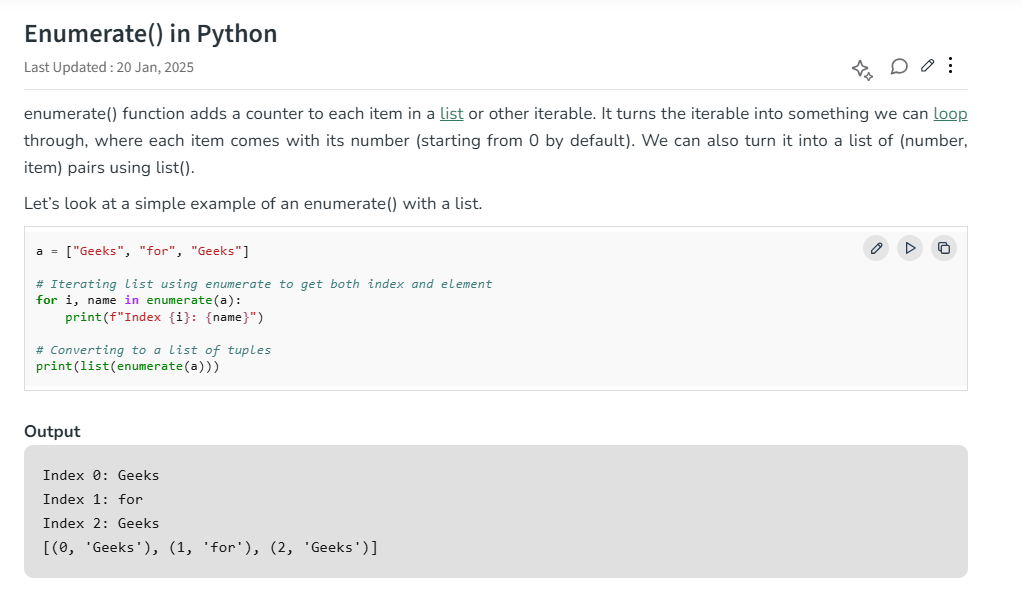


https://www.geeksforgeeks.org/enumerate-in-python/

In [ ]:
#this function takes a neural0net call as argument,
#together with the number of epochs, dataets, and batch-size
#I have written it like this to make sure you remember to inizializse a new NN
#(I can redifine at my plasear).

def define_and_train(NN_class, n_ephochs, training_set, test_set, batch_size=32, weight_decay = 0.0):

    trainingLoader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
    testLoader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

    theNet = NN_class()

    optimizer = optim.Adam(theNet.parameters(),weight_decay=weight_decay) # Adam is include of L2 regularization
    
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    val_error_rate = []
    train_error_rate = []

    for epochs in range(n_ephochs): # nunmber of time to loop over the dataset

        
        total_loss = 0
        total_correct = 0
        total_examples = 0
        n_mini_batchers = 0

        for i, n_mini_batch in enumerate(trainloader, 0):
            images, labels = n_mini_batch


            # zero the parameter gradients
            # all the parameters that are being updated are in the optimizer, 
            # so if we zero the gradients of all the tensors in the optimizer, 
            # that is the safest way to zero all the gradients.
            optimizer.zero_grad()

            outputs = theNet(images) # this is the forward pass

            loss = loss_function(outputs, labels)

            loss.backward() #does the backward pass adnd computes all gradients
            
            optimizer.step() # upfdate all the weight

            n_mini_batchers += 1  #keep track of number of minibatches
            total_loss += loss.item() #remember thw loss is zero order tensor . 
                                        # it summ up all loss for each batches
            
            #keep track of number of examples, and collect number of the rightr predictions.
            total_correct += sum((outputs > 0.5) == (labels > 0.5)).item()
            total_examples += len(labels)

        #calcualte probabilistic  for each epoch and print them.
        #YOU CAN ALTER THIS CODE TO ACCUMULATE THERSE STATISTICS INTO LIST/VECTORS AND PLOT THEM.
        epoch_training_accuracy = total_correct / total_examples
        epoch_training_loss = total_loss / n_mini_batchers
        epoch_training_error_rate = 1 - epoch_training_accuracy

        #call function for validation set 
        epoch_validation_accuracy, epoch_validation_loss, epoch_validation_error_rate = accuracy_and_loss_erorrRate(theNet,loss_function,testLoader)
        
        print('Epoch %d loss: %.3f acc: %.3f val_loss: %.3f val_acc: %.3f val_error_rate %.3f'
              %(epochs+1, epoch_training_loss, epoch_training_accuracy, epoch_validation_loss, epoch_validation_accuracy, epoch_validation_error_rate ))
        

        train_loss.append(epoch_training_loss)
        train_acc.append(epoch_training_accuracy)
        val_acc.append(epoch_validation_accuracy)
        val_error_rate.append(epoch_validation_error_rate)
        val_loss.append(epoch_validation_loss)
        train_error_rate.append(epoch_training_error_rate)

    history = {
            'train_loss':train_loss,
            'train_acc':train_acc,
            'val_loss':val_loss,
            'val_error_rate':val_error_rate,
            'val_acc':val_acc,
            'train_error_rate':train_error_rate

    
        }

    return (history, theNet, np.min(val_error_rate))
 






In [139]:
big_training_data = make_percolation_datasets(n_examples=10000)

C:\Users\papap\AppData\Local\Temp\ipykernel_18560\2317440995.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [(torch.tensor(x.astype(np.float32)).reshape(1,8,8), torch.tensor(float(y)).reshape(1) )  for x,y in zip( X_data, Y_data)]


In [ ]:
hystory1, net1, error_rate, epoch = define_and_train(NN_one_hidden, 50, training_set, test_set,batch_size=32,
                                  weight_decay=0.00000)

print(f"the best error rate is {error_rate}")

Epoch 1 loss: 0.696 acc: 0.503 val_loss: 0.688 val_acc: 0.523 val_error_rate 0.477
Epoch 2 loss: 0.682 acc: 0.570 val_loss: 0.683 val_acc: 0.586 val_error_rate 0.414
Epoch 3 loss: 0.673 acc: 0.611 val_loss: 0.679 val_acc: 0.585 val_error_rate 0.415
Epoch 4 loss: 0.659 acc: 0.644 val_loss: 0.677 val_acc: 0.575 val_error_rate 0.425
Epoch 5 loss: 0.651 acc: 0.661 val_loss: 0.669 val_acc: 0.602 val_error_rate 0.398
Epoch 6 loss: 0.641 acc: 0.687 val_loss: 0.669 val_acc: 0.593 val_error_rate 0.407
Epoch 7 loss: 0.626 acc: 0.704 val_loss: 0.665 val_acc: 0.598 val_error_rate 0.402
Epoch 8 loss: 0.613 acc: 0.703 val_loss: 0.673 val_acc: 0.585 val_error_rate 0.415
Epoch 9 loss: 0.609 acc: 0.702 val_loss: 0.662 val_acc: 0.604 val_error_rate 0.396
Epoch 10 loss: 0.594 acc: 0.713 val_loss: 0.671 val_acc: 0.597 val_error_rate 0.403
Epoch 11 loss: 0.591 acc: 0.724 val_loss: 0.667 val_acc: 0.608 val_error_rate 0.392
Epoch 12 loss: 0.570 acc: 0.753 val_loss: 0.652 val_acc: 0.610 val_error_rate 0.390
E

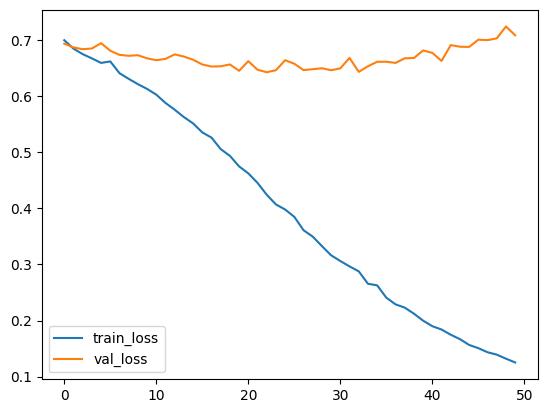

In [128]:
#plot the is hystory
#this is a really good pratics

plt.plot(hystory1['train_loss'], label='train_loss')
plt.plot(hystory1['val_loss'], label='val_loss')
plt.legend()

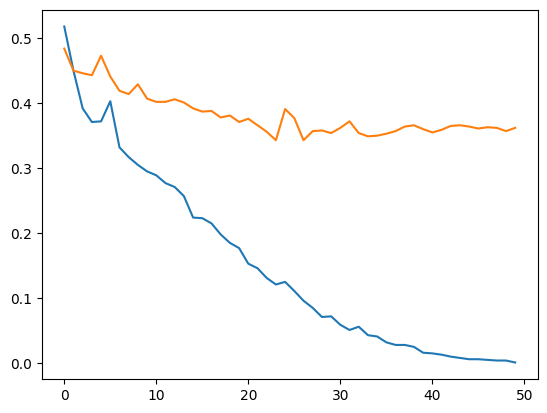

In [127]:
plt.plot(hystory1['train_error_rate'], label='train_error_rate')
plt.plot(hystory1['val_error_rate'], label='val_error_rate')

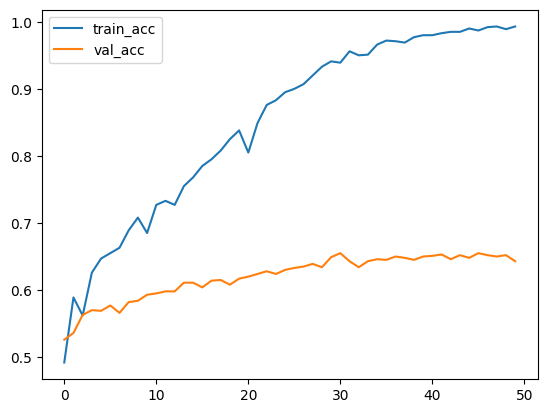

In [134]:
plt.plot(hystory1['train_acc'],label='train_acc')
plt.plot(hystory1['val_acc'], label='val_acc')
plt.legend()

### A convolutional model for detecting percolation

Since percolation depends on local properties of the image, a better strategy may be to used a convolutional model, like the one defined below. 

After some messing about, I found that the model defined has reasonable (but not perfect) performance.  Please try to find a better one ! I was a little disappointed that I found that max-pooling layers seemed to slightly reduce performance, but you might find differently.  

Perhaps some 1x1 convolutions might improve performance?  I haven't tried them. 

Your challenge is to try this model out, and then to do some experiments. (To do experiments, you will need to be tidy: I suggest  

* For a small training set size (say 1000) examine the effect of different types and levels of regularisation. Try putting in `l1` and `l2` regularisation, and dropout (try each separately). 
    When adding `l1` or `l2` regularisation, a reasonable amount to add is in the region of 
    0.00001 to 0.001 .  Larger amounts of regularisation will just force all the weights towards zero. 

* How does validation error vary with training set size?  This is an important question!  Plot  log validation error versus  log training set size, in the range from 100 to 32000 (or 100000 if you have the time)  Plot a log-log graph, and see if you can identify a power law, visible as a straight(ish) line on the graph.  

### Constructing a convolutional model in Pytorch

We need to keep track of the sizes of the tensors as we build a convolutional net.

One easy way to do this is to evaluate part of the network, using zeros as inputs, and look at the shape of the resulting tensor. 